<a href="https://colab.research.google.com/github/gstrother/wami-maths/blob/main/WAMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class XP

In [ ]:
import math

class Classes:
  def battle_mage(stage):
    return (stage ** (1 + (stage / 1000)))

  def druid(mrefill):
    return (math.log(mrefill))

  def conjurer(level):
    return (level ** (1 + (level / 5000)))
  
  def demonist(demons):
    return ((demons * 1000) ** (1 + (demons / 200)))

  def beastmaster(zone):
    return ((zone ** (1 + (zone / 10))) * 2)

  def animist(training_level):
    return (training_level ** (1 + (training_level / 250)))


In [ ]:
wami_classes = Classes
seconds_required = 0

for i in range(1, 25):
  seconds_required = seconds_required + ((50000 * i) / wami_classes.animist(50)) 

print ((int)(seconds_required/60), " minutes for animist 1->150")
print ((int)(seconds_required/60/60), " hours for animist 1->150")


2286  minutes for animist 1->150
38  hours for animist 1->150


# Arena

In [ ]:
from random import random
# Class to store some functions and parameters for WAMI's Dark Shadow arena class
class ArenaProgress:
  def __init__(self, 
               arena_damage_level = 1,    # default arena damage level to 1
               freeze_chance_level = 1,   # default freeze chance to level 1
               freeze_duration = 2,       # default freeze duration to level 2
               attack_speed_level = 1):   # default attack speed to level 1
    # if any of the variables are passed, update the class 
    #   instance vars (e.g. "self")
    self.arena_damage_level = arena_damage_level
    self.freeze_chance_level = freeze_chance_level
    self.freeze_duration = freeze_duration
    self.attack_speed_level = attack_speed_level
    # calculated variables that belong to each class instance 
    self.base_damage = arena_damage_level * 20
    self.damage = self.base_damage * (1.01**arena_damage_level) 
  
  # function that will calculate estimated time to kill based only on 
  #   attack speed and damage. does NOT use crit / freeze
  # EXAMPLE - stage_duration(stage=200) : returns double representing seconds to kill
  def stage_duration(self, stage: int):
    stage_hit_points = 300 * (1.08**stage)
    time_to_kill = stage_hit_points / (self.damage * 2/(1+(1.02*self.attack_speed_level)))  # fixed to be multiplicative instead of exponential - ##gps 8/9/2021
    return time_to_kill
  
  # function that will estimate total duration given a set number seconds and 
  #   stage.  This assumes all time is spent on ONE stage, does NOT take into
  #   account how long a stage may take to kill.
  def freeze_reduction_over_time(self, seconds: int, stage: int):
    attack_speed = 2 / (1.02*self.attack_speed_level)  # fixed to be multiplicative instead of exponential - ##gps 8/9/2021
    freeze_chance = (1.02 ** self.freeze_chance_level) / stage  # set baseline freeze chance which is 1.02^freeze_change divided by the stage #
    is_frozen = False  # default frozen to be false 
    total_duration = 0  # total duration counter, defaulted to zero and will be updated shorted 
    frozen_time_left = self.freeze_duration  # set frozen time to be equal to freeze duration, this will decrement as rounds pass and freeze doesn't proc
    total_damage = 0  # initial damage starts at zero and will increment each round by atk dmg
    while seconds > 0:  
      # increment from 0 to seconds at time increments of attackspeed
      rand = random()   # seed a random number to see if we "proc" freeze
      # print("freeze_chance: {0}, rand: {1}".format(freeze_chance,rand))
      if freeze_chance >= rand:
        # we proc'd freeze!
        is_frozen = True
        # reset freeze time to full duration
        frozen_time_left = self.freeze_duration
        # multiply current freeze chance by 0.9 since oni math
        freeze_chance = freeze_chance * 0.9
      else:
        # we DIDN'T proc freeze
        if is_frozen:
          # if we're already frozen, decrease freeze time by atk spd time (e.g. length of a round for this loop)
          frozen_time_left = frozen_time_left - attack_speed
          # if after subtracting atk speed from frozen time, if it's less than or equal to zero, the mob isn't frozen anymore
          if frozen_time_left <= 0:
            is_frozen = False
        else:
          # we DIDN'T proc freeze AND the mob isn't already frozen, the we decrement the actual seconds 
          seconds = seconds - attack_speed
      # increment total damage and total duration
      total_damage = total_damage + self.damage
      total_duration = total_duration + attack_speed 
    # return two numbers  (the total duration and total damage)
    return total_duration, total_damage

In [ ]:
# How increasing attack speed affects total duration with freeze chance and how the damage scales 
import numpy as np
import matplotlib.pyplot as plt

# ds_test = ArenaProgress(arena_damage_level=191, freeze_chance_level=211, freeze_duration=5, attack_speed_level=91)
# print("stage 150: {} seconds".format(ds_test.stage_duration(150)))

# make new empty arrays (lists) to be used for total rounds 
damage = []
duration = []
for atk_speed in range (87, 140, 5):   # range (141, 151, 1) will iterate from 141 to (but not including) 151 in increments of 1
  # make a new class instance of Arena Progress using atk_speed from the above loop.
  # we'll add each of these instances to be above listed damage/duration lists
  ds_test = ArenaProgress(arena_damage_level=160,  # change these as you see fit
                          freeze_chance_level=198,  # change these as you see fit 
                          freeze_duration=4,  # change these as you see fit 
                          attack_speed_level=(atk_speed))
  # make two new numpy vectors of size (50,) (think of this like a one dimentional list of 50 items long)
  temp_damage = np.empty((50,))
  temp_duration = np.empty((50,))
  for run in range (0,50,1):
    # for each of 50 runs, update the two vectors with the result of the ArenaProgress's freeze_reduction over time.
    # 
    # freeze_reduction_over_time returns TWO numbers, so we assign those to each numpy vector at 
    #   the [run] (which is our iterator of our for loop) location  
    temp_duration[run], temp_damage[run] = ds_test.freeze_reduction_over_time(60,220)
  # let numpy calculate the mean for each numpy vector and store it in our array lists
  damage.append(temp_damage.mean())
  duration.append(temp_duration.mean())

# build two numpy arrays using our lists that we build from the for loop
np_dmg = np.array(damage)
np_duration = np.array(duration)
# print("average duration over 100 iterations: {}".format(np.average(runs, axis=1)))
# print("minimum duration over 100 iterations: {}".format(runs.min()))
# print("maximum duration over 100 iterations: {}".format(runs.max()))
# print("estimated actual duration from 60 seconds: {}".format(ds_test.freeze_reduction_over_time(seconds=60, stage=150)))

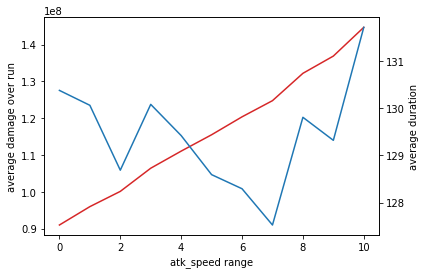

In [ ]:
x = np.linspace(0,10,11)
fig = plt.figure()
dmg_axis = fig.add_subplot()
color = 'tab:red'
dmg_axis.set_xlabel('atk_speed range')
dmg_axis.set_ylabel('average damage over run')
dmg_axis.plot(x, np_dmg, color=color)

color = 'tab:blue'
duration_axis = dmg_axis.twinx()
duration_axis.set_ylabel('average duration')
duration_axis.plot(x, np_duration, color=color)

plt.show()

In [ ]:
print(np_dmg.shape)
print(np_duration.shape)
print(x.shape)

(100,)
(100,)
(50,)


In [ ]:
base_cost = 500
for reduction in range (1, 25, 1):
  sum = 0
  for run in range (1, 7, 1):
    sum = sum + ((base_cost - (reduction * 2)) * run)

  print("for reduction level ", reduction, " total of 7 runs costs: ", sum)


for reduction level  1  total of 7 runs costs:  10458
for reduction level  2  total of 7 runs costs:  10416
for reduction level  3  total of 7 runs costs:  10374
for reduction level  4  total of 7 runs costs:  10332
for reduction level  5  total of 7 runs costs:  10290
for reduction level  6  total of 7 runs costs:  10248
for reduction level  7  total of 7 runs costs:  10206
for reduction level  8  total of 7 runs costs:  10164
for reduction level  9  total of 7 runs costs:  10122
for reduction level  10  total of 7 runs costs:  10080
for reduction level  11  total of 7 runs costs:  10038
for reduction level  12  total of 7 runs costs:  9996
for reduction level  13  total of 7 runs costs:  9954
for reduction level  14  total of 7 runs costs:  9912
for reduction level  15  total of 7 runs costs:  9870
for reduction level  16  total of 7 runs costs:  9828
for reduction level  17  total of 7 runs costs:  9786
for reduction level  18  total of 7 runs costs:  9744
for reduction level  19  t

# Dumpbump

## Original DumpBump off/def

In [ ]:
import numpy as np
def token_spread(dump_tokens: int, do_print=True):
  tokens_start = dump_tokens
  one_cost_levels = np.zeros(5, dtype=np.int16) #make a new array of size 5, filled with zeroes as integers
  two_cost_levels = np.zeros(5, dtype=np.int16) #make a new array of size 5, filled with zeroes as integers
  off_def_level = 0
  round = 0
  should_we_continue = True
  while should_we_continue:
    round += 1
    for iterator in range(0, 5, 1): 
      if dump_tokens <= 0 or dump_tokens - round < 0: 
        should_we_continue = False
        break
      off_def_level += 1
      one_cost_levels[iterator] += 1
      dump_tokens -= round

    if round % 2 == 0:    # if level is divisible by 2, buy 
      for iterator in range(0, 5, 1):
        if dump_tokens <= 0 or dump_tokens - round < 0:
          should_we_continue = False
          break
        off_def_level += 1
        two_cost_levels[iterator] += 1
        dump_tokens -= round
    # print("dump tokens left: {0}".format(dump_tokens))
    # print("one cost levelS: {0} | two cost levels: {1} | off/def levels: {2}, off_def % : {3:.2e}"
    #       .format(one_cost_levels, two_cost_levels, off_def_level, 1.02**off_def_level))
  off_def_bonus = 1.02**off_def_level - 1    
  #the finale
  if do_print: 
    print("Tokens Spent: {0}\n".format(tokens_start - dump_tokens))
    print("Mrefill lvl {0} bonus: {1:.2%}".format(one_cost_levels[0],1.02**one_cost_levels[0] - 1) )
    print("    Exp lvl {0} bonus: {1:.2%}".format(one_cost_levels[1],1.02**one_cost_levels[1] - 1) )
    print("Dungeon lvl {0} bonus: {1:.2%}".format(one_cost_levels[2],1.02**one_cost_levels[2] - 1) )
    print("   Gold lvl {0} bonus: {1:.2%}".format(one_cost_levels[3],1.02**one_cost_levels[3] - 1) )
    print("   MPow lvl {0} bonus: {1:.2%}\n".format(one_cost_levels[4],1.02**one_cost_levels[4] - 1) )

    print("Essence lvl {0} bonus: {1:.2%}".format(two_cost_levels[0],1.02**two_cost_levels[0] - 1) )
    print("  Perks lvl {0} bonus: {1:.2%}".format(two_cost_levels[1],1.02**two_cost_levels[1] - 1) )
    print("Syn Exp lvl {0} bonus: {1:.2%}".format(two_cost_levels[2],1.02**two_cost_levels[2] - 1) )
    print("ClassXP lvl {0} bonus: {1:.2%}".format(two_cost_levels[3],1.02**two_cost_levels[3] - 1) )
    print("     DE lvl {0} bonus: {1:.2%}\n".format(two_cost_levels[4],1.02**two_cost_levels[4] - 1) )

    print("Off/Def Bonus: {0:.2e}".format(off_def_bonus))
    print("------------------------------")
  return off_def_bonus

token_spread(42904)
# token_array = {}
# for tokens in range(2700, 2700*6,2700): 
#   bonus = token_spread(tokens)
#   token_array[tokens] = bonus

# prev_off = 1
# for k,v in token_array.items():
#   print("tokens {0} -> off/def bonus: {1:.2%}  ||  gain: {2:.2%} ".format(k,v, v/prev_off))
#   prev_off = v


Tokens Spent: 42879

Mrefill lvl 107 bonus: 732.18%
    Exp lvl 107 bonus: 732.18%
Dungeon lvl 106 bonus: 715.86%
   Gold lvl 106 bonus: 715.86%
   MPow lvl 106 bonus: 715.86%

Essence lvl 53 bonus: 185.63%
  Perks lvl 53 bonus: 185.63%
Syn Exp lvl 53 bonus: 185.63%
ClassXP lvl 53 bonus: 185.63%
     DE lvl 53 bonus: 185.63%

Off/Def Bonus: 7.15e+06
------------------------------


7150506.956795651

## off/def optimizer

In [ ]:
import numpy as np
debug = False
#region inputs
tokens = 125000
reset_percent = 0.28 # percent as a decimal
current_perm_off_def = 1807.7 # as a decimal or e notation
#endregion inputs
optimal_off_def_bonus, optimal_temp_tokens, optimal_perm_tokens = 0, 0, 0# init some empty vars
bonus_array = [] 

for n in range (0, tokens, tokens//100):
  perm_tokens = n
  temp_tokens = tokens - n 
  perm_bonus = (token_spread(do_print=False, dump_tokens=perm_tokens) * reset_percent) + current_perm_off_def 
  temp_bonus = token_spread(do_print=False, dump_tokens=temp_tokens) 
  total_bonus = perm_bonus * temp_bonus
  if debug:
    print("temp tokens {0} gives {1:.2e} bonus".format(temp_tokens, temp_bonus))
    print("perm tokens {0} gives {1:.2e} bonus".format(perm_tokens, perm_bonus))
    print("total bonus: {0:.2e}".format(total_bonus))
  bonus_array.append((total_bonus, temp_bonus, perm_bonus))
  if total_bonus > optimal_off_def_bonus:
    optimal_off_def_bonus = total_bonus
    optimal_perm_tokens = perm_tokens
    optimal_temp_tokens = temp_tokens 

optimal_perm_tokens: 62500
optimal_temp_tokens: 62500
Total Tokens Spent (( 125000 )) for a total off/def: 1.03e+16
Total Perm bonus after reset: 2.45e+08


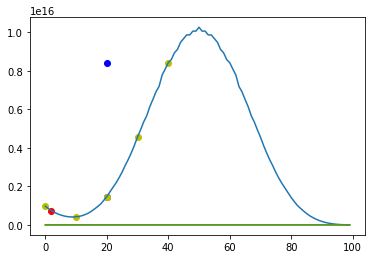

All temp bonus: 8.48e+14 -> leads to total perm bonus of 1.31e+11
All perm bonus: 1.62e+12


In [ ]:
import matplotlib.pyplot as plt

print("optimal_perm_tokens: {}".format(optimal_perm_tokens))
print("optimal_temp_tokens: {}".format(optimal_temp_tokens))
print("Total Tokens Spent (( {0} )) for a total off/def: {1:.2e}"
      .format(optimal_perm_tokens+optimal_temp_tokens, optimal_off_def_bonus))
print("Total Perm bonus after reset: {0:.2e}"
      .format(token_spread(do_print=False, dump_tokens=optimal_temp_tokens) * reset_percent
              + token_spread(do_print=False, dump_tokens=optimal_perm_tokens)
              + current_perm_off_def))

plt.plot(bonus_array)
plt.scatter(2, bonus_array[2][0], c="r")
plt.scatter(20, bonus_array[20][0], c="b")
plt.scatter(20, bonus_array[40][0], c="b")
for i in range(0,50, 10):
  plt.scatter(i, bonus_array[i][0], c='y')
plt.show()

print("All temp bonus: {0:.2e} -> leads to total perm bonus of {1:.2e}"
      .format(bonus_array[1][0], bonus_array[1][1] * reset_percent + bonus_array[1][2] ))
print("All perm bonus: {0:.2e}".format(bonus_array[-1][0]))

## DumpBump Class

In [ ]:
from functools import cmp_to_key
class DumpBumpBuff:
  def __init__(self, level = 0, priority = 1, base_cost = 1):
    self.level = 0
    self.priority = priority
    self.bonus = 1.02**self.level
    self.base_cost = base_cost

  def __str__(self):
    return "Level: {0}, Priority: {1}, Bonus: {2}".format(self.level, 
                                                          self.priority, 
                                                          self.bonus)
            
  def __repl__(self):
    # print((self.priority / self.base_cost) * (self.level + 1))
    return((self.priority / self.base_cost) * (self.level + 1))

  def comparator(a, b):
    if a < b:
      return -1
    elif a == b:
      return 0
    else:
      return 1 


class DumpBump:
  def __init__(self):
    self.buffs = {
      'mrefill': DumpBumpBuff(level=0, priority=1, base_cost=1),
      'exp': DumpBumpBuff(level=0, priority=1, base_cost=1),
      'mpow': DumpBumpBuff(level=0, priority=1, base_cost=1),
      'dungeon': DumpBumpBuff(level=0, priority=1, base_cost=1),
      'gold': DumpBumpBuff(level=0, priority=1, base_cost=1),
      'essence': DumpBumpBuff(level=0, priority=1, base_cost=2),
      'synexp': DumpBumpBuff(level=0, priority=1, base_cost=2),
      'perks': DumpBumpBuff(level=0, priority=1, base_cost=2),
      'classexp': DumpBumpBuff(level=0, priority=1, base_cost=2),
      'de': DumpBumpBuff(level=0, priority=1, base_cost=2),
    }
    self.tokens = 0
    self.off_def_level = 0
    self.tokens_spent = 0 


  def dump_off_def(self, dump_tokens):
    self.tokens = dump_tokens
    self.off_def_level  = 0
    should_we_continue = True
    while should_we_continue:
      # make a new dict to store "ranked" buffs based on priority
      buff_list = {}
      # rank buffs, add em to the dict
      for k,v in self.buffs.items():
        buff_score = int((v.priority / v.base_cost)* 2)
        buff_list[k] = buff_score
      # make a sorted dict of buffs so we level the highest priority first
      sorted_buffs = dict(sorted(buff_list.items(), key=lambda item: item[1], reverse=True))
      # iterate through the buffs 
      for buff, priority in sorted_buffs.items():
        # and level them the number of times priority is set to
        for number_of_levels in range(0, priority, 1):
          # if we can't level the next prioritized buff, try the next one!
          if self.tokens <= 0 \
              or self.tokens - ((self.buffs[buff].level+1) * self.buffs[buff].base_cost)  < 0: 
            should_we_continue = False
            break  
          else:
            # if we can afford it, level the damn buff!
            self.__level_buff__(self.buffs[buff])
          # increment off def
          self.off_def_level
          self.tokens_spent = dump_tokens - self.tokens
    #the finale
    return 1.002**self.off_def_level 


  # helper method to handle leveling each buff 
  def __level_buff__(self, buff: DumpBumpBuff):
      if self.tokens - (buff.level+1) * buff.base_cost < 0:
        return
      else:
        buff.level += 1
        self.tokens -= buff.level * buff.base_cost
        self.off_def_level  += 1
  

  def __str__(self):
    ret_str = "off/def bonus: {0:.2e}\n".format(1.02**self.off_def_level)
    for k,v in self.buffs.items():
      ret_str = ret_str + k + " bonus: " + str(self.buffs[k]) + "\n"
    return ret_str
  

  def print(self):
    print("Tokens Spent: {0}\n".format(self.tokens_spent) + 
          "Mrefill lvl {0} bonus: {1:.2%}\n".format(self.buffs['mrefill'].level,1.02**self.buffs['mrefill'].level - 1) +
          "    Exp lvl {0} bonus: {1:.2%}\n".format(self.buffs['exp'].level,1.02**self.buffs['exp'].level - 1) +
          "Dungeon lvl {0} bonus: {1:.2%}\n".format(self.buffs['dungeon'].level,1.02**self.buffs['dungeon'].level - 1) +
          "   Gold lvl {0} bonus: {1:.2%}\n".format(self.buffs['gold'].level,1.02**self.buffs['gold'].level - 1) +
          "   MPow lvl {0} bonus: {1:.2%}\n".format(self.buffs['mpow'].level,1.02**self.buffs['mpow'].level - 1) +
          "Essence lvl {0} bonus: {1:.2%}\n".format(self.buffs['essence'].level,1.02**self.buffs['essence'].level- 1) +
          "  Perks lvl {0} bonus: {1:.2%}\n".format(self.buffs['perks'].level,1.02**self.buffs['perks'].level - 1) +
          "Syn Exp lvl {0} bonus: {1:.2%}\n".format(self.buffs['synexp'].level,1.02**self.buffs['synexp'].level - 1) +
          "ClassXP lvl {0} bonus: {1:.2%}\n".format(self.buffs['classxp'].level,1.02**self.buffs['classxp'].level - 1) +
          "     DE lvl {0} bonus: {1:.2%}\n".format(self.buffs['de'].level,1.02**self.buffs['de'].level - 1) +
          "Off/Def Bonus: {0:.2e}\n".format(1.02**self.off_def_level) +
          "------------------------------\n")


## Test section

In [ ]:
db = DumpBump()

db.buffs['mrefill'].priority = 3.5
db.buffs['exp'].priority = 1
db.buffs['essence'].priority = 1

db.dump_off_def(dump_tokens=44000)

db.print()

Tokens Spent: 43983
Mrefill lvl 238 bonus: 11038.86%
    Exp lvl 70 bonus: 299.96%
Dungeon lvl 68 bonus: 284.43%
   Gold lvl 68 bonus: 284.43%
   MPow lvl 69 bonus: 292.11%
Essence lvl 34 bonus: 96.07%
  Perks lvl 34 bonus: 96.07%
Syn Exp lvl 34 bonus: 96.07%
ClassXP lvl 34 bonus: 96.07%
     DE lvl 34 bonus: 96.07%
Off/Def Bonus: 7.48e+05
------------------------------



In [ ]:
db = DumpBump()

db.buffs['mrefill'].priority = 1
db.buffs['exp'].priority = 1
db.buffs['essence'].priority = 1
db.buffs['dungeon'].priority = 1
db.buffs['mpow'].priority = 1
db.buffs['gold'].priority = 1
db.buffs['perks'].priority = 1
db.buffs['synexp'].priority = 1
db.buffs['classxp'].priority = 1
db.buffs['de'].priority = 1
# if you don't want to level a skill, just set priority to 0
# db.buffs['mpow'].priority = 0
db.dump_off_def(dump_tokens=24248)

db.print()

Tokens Spent: 24240
Mrefill lvl 80 bonus: 387.54%
    Exp lvl 80 bonus: 387.54%
Dungeon lvl 80 bonus: 387.54%
   Gold lvl 80 bonus: 387.54%
   MPow lvl 80 bonus: 387.54%
Essence lvl 40 bonus: 120.80%
  Perks lvl 40 bonus: 120.80%
Syn Exp lvl 40 bonus: 120.80%
ClassXP lvl 39 bonus: 116.47%
     DE lvl 39 bonus: 116.47%
Off/Def Bonus: 1.39e+05
------------------------------

